# MMR - Store Model

### XGBoost Classifier

### Importing Libraries

In [137]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from datetime import datetime
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import tree
from os import system
from graphviz import Source
from sklearn import metrics

### Reading the Dataset and Preprocessing

In [138]:
df=pd.read_csv("C:/Users/anurag.anand/Downloads/store_cluster_xgboost_32_full_data.csv")
df=df.set_index(['Store'])
df.head()

,Tenure,Competitor_Intensity,Area,PD_Base,Weather,Stockout_Perc,Cluster,Gross_Sales,Planned_Sales_Dollar,Deviation_In_Sales,RegionName
Store,,,,,,,,,,,
701,Very_Old,0.0,10000.0,PD,GOOD,0.276686,1,18517.00,19562.91032,-1045.910319,NORTHEAST
2205,Old,3.0,12000.0,PD,GOOD,0.272512,0,33102.61,23474.57012,9628.039879,SOUTHEAST
2356,Old,1.0,15360.0,Base,GOOD,0.270656,0,24325.51,21542.37043,2783.139570,NORTHEAST
172,Very_Old,2.0,11981.0,PD,NaN,0.311051,1,30391.70,32291.25839,-1899.558393,CENTRAL
521,Very_Old,2.0,12004.0,PD,GOOD,0.300957,1,26009.94,24311.00633,1698.933667,SOUTH CENTRAL


In [139]:
## Preprocessing the data. Filling NAs
cleanup_nums = {"Tenure":     {"Very_Old": 1, "Old": 2, "New": 3},
                "Weather": {"GOOD": 1, "BAD": 0},
                   "PD_Base"   : { "PD": 1, "Base": 0 }}

df.replace(cleanup_nums, inplace=True)
df["Weather"] = df.groupby("RegionName")['Weather'].transform(lambda x: x.fillna(x.mean()))

In [140]:
# l = []
# # for i in list(df['RegionName'].unique()):
# temp = df[df['RegionName'] == 'CENTRAL']
# temp
# # mean = np.mean(temp['Weather'])
# temp['Weather'] = temp['Weather'].fillna(mean)
# # l.append(temp)
# # test = pd.concat(l)
# # test[test['RegionName']=='CENTRAL']
# temp
# temp.to_csv("C:/Users/anurag.anand/Downloads/hhsgshhs.csv")

### Splitting the dataset into test and train and running the model

In [141]:
#df.loc[df.Cluster == 2, 'Cluster'] = 1
Y = df['Cluster']
# y = pd.get_dummies(Y)

X =  df[['Tenure','Competitor_Intensity','Area','PD_Base','Weather','Stockout_Perc']]
# data_new = pd.get_dummies(X[['Tenure','PD_Base', 'Weather']])
# X = X.join(data_new)
# X.drop(columns=['PD_Base', 'Weather','PD_Base_Base','Weather_BAD','Tenure'], inplace=True)
X.head()
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.22,random_state=1)
# # # Build the model with the decision tree  algorithm:
dt =  xgb.XGBClassifier(reg_alpha=0.5)
dt.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Predicting the target variable

In [142]:
y_pred = dt.predict(X_test)

### Obtaining Accuracy

In [143]:
print("Accuracy: %.2f %%"%(metrics.accuracy_score(Y_test, y_pred)*100))

Accuracy: 69.31 %


### Plotting the shap values and Interpretation

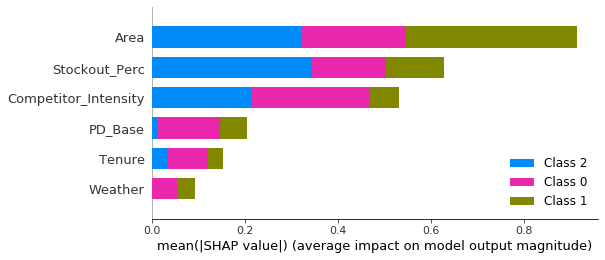

In [144]:
import shap
shap_values = shap.TreeExplainer(dt).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Creating Score table for the Over performing, Closed to plan and Under performing stores


In [145]:
#Create dataframe for Over Performing Stores

a = pd.DataFrame(shap_values[0], columns = [ 'Tenure','Competitor_Intensity','Area','PD_Base','Weather','Stockout_Perc'])

# #Create dataframe for Other Performing Stores

b = pd.DataFrame(shap_values[1], columns = [ 'Tenure','Competitor_Intensity','Area','PD_Base','Weather','Stockout_Perc'])

# #Create dataframe for Under Performing Stores

c = pd.DataFrame(shap_values[2], columns = [ 'Tenure','Competitor_Intensity','Area','PD_Base','Weather','Stockout_Perc'])


In [146]:
#Over Performing Stores
a_shap=a.abs().mean()
a2 = pd.DataFrame(a_shap,columns=['Score'])
a2['Features'] = a2.index
a2['Score'] = a2['Score']/a2['Score'].sum()
#Closed to plan Performing Stores
b_shap=b.abs().mean()
b2 = pd.DataFrame(b_shap,columns=['Score'])
b2['Features'] = b2.index
b2['Score'] = b2['Score']/b2['Score'].sum()
#Under Performing Stores
c_shap=c.abs().mean()
c2 = pd.DataFrame(c_shap,columns=['Score'])
c2['Features'] = c2.index
c2['Score'] = c2['Score']/c2['Score'].sum()

In [147]:
# Converting the dataframes to CSV 

a2.to_csv("C:/Users/anurag.anand/Downloads/final_Score_over_performing.csv")  ## for over performing stores
b2.to_csv("C:/Users/anurag.anand/Downloads/final_Score_closed_to_plan_performing.csv")  ## for closed to plan performing stores
c2.to_csv("C:/Users/anurag.anand/Downloads/final_Score_under_performing.csv")  ## for under performing stores

### END


### --------------------------------------------------------------------------------------------------------------------------